In [38]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu,SmoothingFunction
import pandas as pd
import numpy as np
import docker
import os
import re
import random
from string import punctuation
import json
import matplotlib.pyplot as plt
punc = punctuation
smooth = SmoothingFunction()

In [39]:
#开源项目漏洞数量与gas数量

In [40]:
def mythril_get(bb):
    mythril_result = []
    myt = bb['mythril']
    for index,j in enumerate(myt):
        if j != None and type(j) != float and len(j) > 0:
            total = []
            for i in j:
                #print(i)
                ccode = i.get('code')
                formatted = {
                    #'address':i['address'],
                    #'code':ccode,
                    'function':i['function'],
                    'lineno':i['lineno'],
                    'title':i['title'],
                    'type':i['type']
                }
                total.append(formatted)
            mythril_result.append(total)
        else:
            mythril_result.append([])
    return mythril_result
def slither_get(bb):
    slither_result = []
    sli = bb['slither']
    for index,j in enumerate(sli):
        if j != None and type(j) != float and len(j) > 0:
            temp=[]
            for i in j:
                if len(i['elements']) > 0 and i['elements'][0].get('source_mapping'):
                    func = i['elements'][0].get('name')
                    t = {
                        'title':i['check'],
                        'function':func,
                        #'contract':i['elements'][0].get('contract').get('name'),
                        'lineno':i['elements'][0]['source_mapping']['lines'],
                        'type':i['impact']
                    }
                    temp.append(t)
            slither_result.append(temp)
        else:
            slither_result.append([])
    return slither_result
def osiris_get(bb):
    result = []
    osi = bb['osiris']
    count = 0
    for  index,i in enumerate(osi):
        if i != None and type(i) != float and len(i) > 0:
            temp = []  
            for j in i:
                error = j['errors']
                name = j['name']
                if len(error) > 0:
                    for ttt in error:
                        t = {
                            'title':ttt['message'],
                            'lineno':ttt['line'],
                            'function':name
                        }
                        temp.append(t)
            result.append(temp)
        else:
            result.append([])
    return result
def smallerRange(oldNum, lineNum):
    if len(oldNum) < 1 or len(lineNum) < 1:
        return False
    oldStart = oldNum[0]
    oldEnd = oldNum[-1]
    lineStart = lineNum[0]
    lineEnd = lineNum[-1]
    return lineStart >= oldStart and lineEnd <= oldEnd
def updateMap(res, title, lineNum):
    lineNum = [lineNum] if type(lineNum) == int else lineNum
    lineOldNum = res[title]
    for oldNum in lineOldNum:
        #print(oldNum)
        if smallerRange(oldNum, lineNum):
            return
    res[title].append(lineNum)
    
def subDict(dict1, dict2):
    res = {}
    for item in dict1.keys():
        if item not in dict2.keys():
            res[item] = dict1[item]
        elif dict1[item] - dict2[item] > 0:
            res[item] = dict1[item] - dict2[item]
    return res
    
def getCount(mapRes):
    resCount = {}
    for item in mapRes:
        if len(item) > 0:
            for bugName in item.keys():
                count = len(item[bugName])
                if bugName in resCount.keys():
                    resCount[bugName] += count
                else:
                    resCount[bugName] = count
    return resCount
toolNames = ['mythril_analysis_not_info','osiris_analysis','slither_analysis_not_info']
#toolNames = ['mythril_analysis_not_info','osiris_analysis']
#toolNames = ['mythril_analysis_not_info']
def get(cc, toolNames):
    mapRes = []
    for index,row in cc.iterrows():
        #同行算消除
        res = {}
        for toolName in toolNames:
            toolRes = row[toolName]
            for tRes in toolRes:
                lineNum = tRes['lineno']
                title = mapp[toolName.split('_')[0]][tRes['title'].strip()]#已经转换过
                if title in res.keys():
                    updateMap(res, title, lineNum)
                else:
                    res[title] = [[lineNum] if type(lineNum) == int else lineNum]#使用lineNum--list的len计算数量 [[],[]]
            #temp = [res]
            #print(getCount(temp))
        mapRes.append(res)
    resCount =  getCount(mapRes)
    return resCount

#gas
def patternDeal(sol, num):
    if num == 6:
        return [ 
                {
                    'itemName' : item.split(':')[0],
                    'rows' : [ i.strip() for i in item.split(':')[1].split(',') ]
                      }  for item in sol[1:] if ':' in item and 'uint' in item.split(':')[0] and 'uint256' not in item.split(':')[0]
                ]
    return [ 
                {
                    'itemName' : item.split(':')[0],
                    'rows' : [ i.strip() for i in item.split(':')[1].split(',') ]
                      }  for item in sol[1:] if ':' in item 
                ]

#将结果分割，需要不同的split字符串
def getGasResList(address, num):
    pat = open(address,'r').read()
    patList = re.split('\n[0-9]+ : ', pat)#
    ans = {}
    for sol in patList:
        if 'success' not in sol:
            continue
        sol = sol.split('\n')
        sol = sol[:-1]
        if sol[0] in ans.keys():
            ans[sol[0]] += patternDeal(sol, num)
        else:
            ans[sol[0]] = patternDeal(sol, num)
    return ans

#匹配gasPattern与克隆对的范围
'''def matchRange(item, contract_line):
    return int(item['rows'][0].strip()) >= contract_line[0] and int(item['rows'][1].strip()) <= contract_line[1]'''

#当克隆对合约在patList内，并且范围正确，旧获得
def compareRange(pat, name):

    return  [
        item['rows'] for item in pat[name]
    ] if name in pat.keys() else None

#将gas结果加到bb内
def GasAppendByRange(bb,pat,num):
    bb['pattern{}'.format(num)] = [ compareRange(pat, item[1]['code_name'].split('.')[0]) for item in bb.iterrows() ]

def runGasPattern(patNum, rootAddress, bb):
    for num in patNum:
    #切割
        pat = getGasResList(os.path.join(rootAddress,'gasDetectResult{}.txt').format(num), num)
        GasAppendByRange(bb, pat, num)

In [41]:
#readAddr = '/home/yfliu/paper_data/BugRes_bleu.csv'
readAddr = '/home/yfliu/paper_data/conBugRes.csv'
#storeAddr = '/home/yfliu/paper_data/BugResBleuCompleteRes.pic'
storeAddr = '/home/yfliu/paper_data/BugResCompleteRes.pic'

#bugRes = pd.read_csv('/home/yfliu/paper_data/conBugRes.csv')
#bugRes = pd.read_csv('/home/yfliu/paper_data/BugRes_bleu.csv')
bugRes = pd.read_csv(readAddr)
bugRes['mythril'] = bugRes['mythril'].apply(lambda x : json.loads(x) if type(x) != float else None)
bugRes['slither'] = bugRes['slither'].apply(lambda x : json.loads(x) if type(x) != float else None)
bugRes['osiris'] = bugRes['osiris'].apply(lambda x : json.loads(x) if type(x) != float else None)
bugRes['osiris_analysis'] = osiris_get(bugRes)
bugRes['mythril_analysis'] = mythril_get(bugRes)
bugRes['slither_analysis'] = slither_get(bugRes)
#多种结果mapping到十种情况中
head = [' access_control ',
 ' arithmetic ',
 ' denial_service ',
 ' reentrancy ',
 ' unchecked_low_calls ',
 ' bad_randomness ',
 ' front_running ',
 ' time_manipulation ',
 ' short_addresses ',
 ' Other ',
 ' Ignore ']
dic = dict(zip(head,[0]*10))
mapping = open('/home/yfliu/mapping.json').read()
mapp = json.loads(mapping)
#重要程度

slither_map = mapp['slither']
slither_key = slither_map.keys()
slither_type_map = dict(zip(slither_key,[0]*len(slither_key)))
u = open('/home/yfliu/paper/trash/temp.txt').read()
for i in u.splitlines():
    sp = i.split()
    slither_type_map[sp[1]] = sp[-2]
slither_type_map
slither_type_map['constant-function'] = 'Medium'
slither_bug_patch = ['constable-states','erc20-indexed','erc20-interface','external-function','incorrect-equality','naming-convention','shadowing-local','shadowing-state','shadowing-builtin','shadowing-abstract']
bb = bugRes
slither_temp = list(bb['slither_analysis'])
slither_info = []
for item in slither_temp:
    del_list = []
    info_list = []
    for index,t_item in enumerate(item):
        title = t_item['title']
        level = slither_type_map[title]
        if level == 'Informational' or title in slither_bug_patch:
            del_list.append(index)
    del_list.reverse()
    for tempt in del_list:
        info_list.append(item[tempt])
        del item[tempt]
    slither_info.append(info_list)
bb['slither_analysis_not_info'] = slither_temp
#bb['slither_analysis_info'] = slither_info
slither_temp = list(bb['mythril_analysis'])
slither_info = []
for item in slither_temp:
    del_list = []
    info_list = []
    for index,t_item in enumerate(item):
        #title = t_item['title']
        level = t_item['type']
        if level != 'Warning':
            del_list.append(index)
    del_list.reverse()
    for tempt in del_list:
        info_list.append(item[tempt])
        del item[tempt]
    slither_info.append(info_list)
bb['mythril_analysis_not_info'] = slither_temp

bb['code_name'] = bb['name']    
rootAddress = '/home/yfliu/paper_data/gasPattern/new'
patNum = [1,2,3,4,6,7]
runGasPattern(patNum, rootAddress, bb)
bb.to_pickle(storeAddr)

In [ ]:
#人工机器的比较结果---------暂时废弃

In [ ]:

'''get(bb, ['mythril_analysis_not_info'])

subDict(get(bb, ['mythril_analysis_not_info','osiris_analysis']), get(bb, ['mythril_analysis_not_info']))

subDict(get(bb, ['mythril_analysis_not_info','osiris_analysis','slither_analysis_not_info']), get(bb, ['mythril_analysis_not_info','osiris_analysis']))

print('total:',end = ' ')
total = get(bb, ['mythril_analysis_not_info','osiris_analysis','slither_analysis_not_info'])
count = 0
for item in total:
    count += total[item]
print(total)
print(count)

#根据指定漏洞检测
def getRes(cc, toolName,bugName):
    mapRes = []
    for index,row in cc.iterrows():
        #同行算消除
        #res = {}
        toolRes = row[toolName]
        for tRes in toolRes:
            #lineNum = tRes['lineno']
            total= ''
            title = mapp[toolName.split('_')[0]][tRes['title'].strip()].strip()#已经转换过
            if bugName.strip() == title:
                total = total + json.dumps(tRes) + '\n---------------------\n'
                total = total + row['name'] + '\n---------------------\n'
                name = row['name'] + '.sol'
                text = open('/home/yfliu/data_sol/{}'.format(name)).read()
                total = total + text
                #print(code[code.code_name == row['name']]['code'])
                total = total + '\n============================\n'
            #temp = [res]
            #print(getCount(temp))
                mapRes.append(total)
    return mapRes
    #return resCount
'''
'''ma = getRes(bb, 'mythril_analysis_not_info', ' arithmetic ')

num = 0

print(num + 1)
print(ma[num])
num += 1
'''

In [3]:
#conMan = pd.read_csv('/home/yfliu/paper_data/RQ/RQ1/conCount.csv')
conAst = pd.read_csv('/home/yfliu/paper_data/astResultCsv/contractRes.csv')

In [51]:
conMan = pd.read_csv('/home/yfliu/paper_data/RQ/RQ1/conCountNeedCheckDone.csv',encoding='gbk')
conMan

,sni,bleu,code,check
0,contract FixedSupplyToken is ERC20Interface {\...,0.800498,contract TokenRecover is Ownable {\n\n\n\n \n...,3
1,contract AInterface{},0.801921,contract AssetInterface{},1
2,contract LeonardianCrowdsale is Crowdsale {\n\...,0.802932,contract HKYCrowdsale is CappedCrowdsale {\n\n...,3
3,contract Owned {\n\naddress owner;\n\n constr...,0.803146,contract Owned {\n\n \n address owner;\n...,1
4,contract TestToken is MintableToken {\n\n str...,0.804512,contract OneledgerToken is MintableToken {\n\n...,3
...,...,...,...,...
195,contract Ownable {\n address public owner;\n\...,0.991010,contract Ownable {\n address public owner;\n\...,0
196,contract MyToken {\n \n string public st...,0.992697,contract token {\n \n string public stan...,1
197,contract OpenAddressLottery{\n struct SeedC...,0.993505,contract OpenAddressLottery{\n struct SeedC...,1
198,contract Moderated {\n\n address public...,0.995648,contract Moderated {\n \n address public...,0


In [4]:
funMan = pd.read_csv('/home/yfliu/paper_data/RQ/RQ1/funCount.csv')
funAst = pd.read_csv('/home/yfliu/paper_data/astResultCsv/functionRes.csv')

In [90]:
conBleu = pd.read_csv('/home/yfliu/paper_data/contract_bleu_ast_all.csv')
conBleu['sni_index'] =conBleu['index']
conTemp = conBleu.merge(conAst,on=['sni_index'])

In [96]:
conBleuRange = conTemp['match'].apply(lambda x : eval(x)[0][1])
conTemp['matchRange'] = conBleuRange

In [102]:
xRange = list(np.arange(0,1,0.1))
xRange.append(1)
xRange.append(1.1)
l = []
for idx in range(len(xRange) - 1):
    xrange = [xRange[idx], xRange[idx + 1]]
    temp = conTemp[conTemp['matchRange'].apply(lambda x : x >= xrange[0] and x < xrange[1])]
   
    l.append(len(temp))
    #xRange = list(np.arange(0.8,1,0.01))
l

[7, 56, 88, 95, 119, 94, 62, 44, 42, 122, 391]

In [103]:
xRange

[0.0,
 0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6000000000000001,
 0.7000000000000001,
 0.8,
 0.9,
 1,
 1.1]

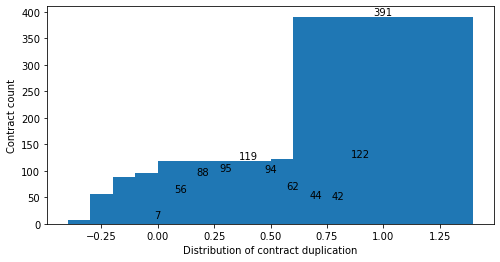

In [109]:
def barr(keys,values):
    fig = plt.figure(figsize=(8,4))
    plt.bar(keys, values)
    for a,b in zip(keys,values):
        plt.text(a, b+0.01, '%.0f' % b, ha='center', va= 'bottom')
    plt.xticks()
    plt.xlabel("Distribution of contract duplication")
    plt.ylabel("Contract count")
    plt.show()

barr(xRange[:-1],l)

In [53]:
conMan['sni_code'] = conMan['sni']
funMan['sni_code'] = funMan['sni']

In [57]:
conMan = conMan[conMan['check'].apply(lambda x : int(x) < 2)]

In [26]:
conAst['code'] = conAst['contract_code']

In [60]:
temp = conAst.merge(conMan,on = 'sni_code',how = 'right')
temp = temp[temp['code_name'].apply(lambda x : type(x) != str)]

In [58]:
conAst.merge(conMan,on = 'sni_code',how = 'inner')

,index,sni_index,code_index,code_name,dealed_code,sni_name,contract_code,sni_code,contract_line,name,...,osiris_analysis,mythril_analysis,slither_analysis,slither_analysis_not_info,mythril_analysis_not_info,code_x,sni,bleu,code_y,check
0,9,111,716,0x439f4b2d7b7dfcde4d63efb075ebe250613bebd6.sol,"['contract', 'mortal', 'address', 'owner', 'fu...",5862-0.sol,contract mortal\n{\n address owner;\n\n ...,contract mortal { address owner; function mort...,"[2, 34]",0x439f4b2d7b7dfcde4d63efb075ebe250613bebd6,...,[],[],[],[],[],contract mortal\n{\n address owner;\n\n ...,contract mortal { address owner; function mort...,0.914208,contract mortal\n{\n address owner;\n\n ...,1
1,15,32,2847,0x1a8ee1619397329de9b1161ed59d937744fdcc9d.sol,"['contract', 'Greeter', 'is', 'Mortal', 'strin...",7028-0.sol,contract Greeter is Mortal {\n \n string...,contract greeter is mortal { string greeting; ...,"[11, 24]",0x1a8ee1619397329de9b1161ed59d937744fdcc9d,...,[],[],[],[],[],contract Greeter is Mortal {\n \n string...,contract greeter is mortal { string greeting; ...,0.964150,contract Greeter is Mortal {\n \n string...,1
2,32,51,312,0x9f623e51165102c1b7febbbbc25b76c751633155.sol,"['contract', 'Owned', 'address', 'public', 'ow...",72935-0.sol,contract Owned {\n address public owner;\n ...,contract Owned {\n address public owner;\n ...,"[72, 96]",0x9f623e51165102c1b7febbbbc25b76c751633155,...,[],[],[],[],[],contract Owned {\n address public owner;\n ...,contract Owned {\n address public owner;\n ...,0.970580,contract Owned {\n\n address public owner;\...,0
3,34,2953,310,0x9f623e51165102c1b7febbbbc25b76c751633155.sol,"['contract', 'ERC20Interface', 'function', 'to...",80533-0.sol,contract ERC20Interface {\n function totalS...,contract ERC20Interface {\n function totalS...,"[46, 56]",0x9f623e51165102c1b7febbbbc25b76c751633155,...,[],[],[],[],[],contract ERC20Interface {\n function totalS...,contract ERC20Interface {\n function totalS...,0.941374,contract ERC20Interface {\n \n function ...,1
4,54,2021,68172,0x4601c5442f97b9c14f335720b935d59642f1ffaf.sol,"['contract', 'Ownable', 'address', 'owner', 'f...",12843-1.sol,contract Ownable {\n address owner;\n funct...,contract owned {\n address owner;\n function...,"[5, 10]",0x4601c5442f97b9c14f335720b935d59642f1ffaf,...,[],[],[],[],[],contract Ownable {\n address owner;\n funct...,contract owned {\n address owner;\n function...,0.823880,contract Ownable {\n address owner;\n funct...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,1059,5572,66569,0x5712a71287b8096Aad806059b0F0e5e31Fb575D1.sol,"['contract', 'ERC20', 'is', 'ERC20Basic', 'fun...",79080-0-0.sol,contract ERC20 is ERC20Basic {\n function a...,contract ERC20 is ERC20Basic {\n function a...,"[96, 101]",0x5712a71287b8096Aad806059b0F0e5e31Fb575D1,...,[],[],[],[],[],contract ERC20 is ERC20Basic {\n function a...,contract ERC20 is ERC20Basic {\n function a...,0.925984,contract ERC20 is ERC20Basic {\n\n function a...,1
94,1070,5881,47072,0x57d90b64a1a57749b0f932f1a3395792e12e7055.sol,"['contract', 'PotRewards', 'function', 'transf...",17323-0-0.sol,contract PotRewards {\n function transfer(a...,contract ERC20Token {\n function transferFrom...,"[6, 8]",0x57d90b64a1a57749b0f932f1a3395792e12e7055,...,[],[],[],[],[],contract PotRewards {\n function transfer(a...,contract ERC20Token {\n function transferFrom...,0.861677,contract ERC721 {\n\n\n\n function transferFr...,1
95,1073,5916,4640,0x2bbca37e5fd308c406fa4d9a07897fc12df0afef.sol,"['contract', 'Faucet', 'function', 'withdrawui...",51638-0-0.sol,contract Faucet {\n\n \n\n \n\n funct...,contract Faucet {\n\n \n function withdr...,"[1282, 1312]",0x2bbca37e5fd308c406fa4d9a07897fc12df0afef,...,[],[],[],[],[],contract Faucet {\n\n \n\n \n\n funct...,contract Faucet {\n\n \n function withdr...,0.945114,contract Faucet {\n\n \n\n \n\n funct...,1
96,1101,6842,1915,0x7900a696ff44253536e128cddbe10079cfd33fca.sol,"['contract', 'ReceivingContractCallback', 'fun...",66736-0-0.sol,

In [18]:
len(funAst.merge(funMan,on = 'sni_code',how = 'inner'))

,index,sni_index_x,code_index_x,code_name,dealed_code,sni_name,contract_code,sni_code,contract_line,name,...,mythril_analysis,slither_analysis,slither_analysis_not_info,mythril_analysis_not_info,sni_index_y,code_index_y,sni,bleu,code,check
0,3,21,10964,0x59524c5088fa3a7a1c441940061219c65b486474.sol,"['function', 'assertbool', 'assertion', 'inter...",47952-0.sol,function assert(bool assertion) internal {\n ...,function assert(bool assertion) internal {\n ...,"[199, 203]",0x59524c5088fa3a7a1c441940061219c65b486474,...,[],[],[],[],21,312,function assert(bool assertion) internal {\n ...,0.932199,function assert(bool assertion) internal {\n ...,0
1,8,2350,85,0x1b94e0F5F404271633a0Cc1c4cd29A2287f84DeC.sol,"['function', 'external', 'payable']",58197-0.sol,function() external payable {},function deposit()\n external\n payable { },"[397, 398]",0x1b94e0F5F404271633a0Cc1c4cd29A2287f84DeC,...,[],[],[],[],2350,2597,function deposit()\n external\n payable { },0.970727,function () payable external { deposit(); },0
2,9,4859,85,0x1b94e0F5F404271633a0Cc1c4cd29A2287f84DeC.sol,"['function', 'external', 'payable']",65660-0-1.sol,function() external payable {},function () payable external {\n...\n},"[397, 398]",0x1b94e0F5F404271633a0Cc1c4cd29A2287f84DeC,...,[],[],[],[],4859,85,function () payable external {\n...\n},0.960559,function() external payable {},0
3,21,46,17217,0x79e10a7324e97ef9d6ab9f5dd069b847f99ee851.sol,"['function', 'checkGoalReached', 'afterDeadlin...",15989-2.sol,function checkGoalReached() afterDeadline {\n ...,function checkGoalReached() afterDeadline {\n ...,"[58, 64]",0x79e10a7324e97ef9d6ab9f5dd069b847f99ee851,...,[],[],[],[],46,5410,function checkGoalReached() afterDeadline {\n ...,0.938103,function checkGoalReached() afterDeadline only...,0
4,37,5604,708,0xc5b106f17246b2f5c0c658dbd6e8d168695806ab.sol,"['function', 'setNamestring', 'name', 'isOwner...",19171-0-1.sol,function setName(string _name) isOwner {\n\n ...,function setContactInformation(string info) on...,"[212, 216]",0xc5b106f17246b2f5c0c658dbd6e8d168695806ab,...,[],[],[],[],5604,2898,function setContactInformation(string info) on...,0.942784,function setContactInformation(string info) on...,0
5,40,656,2251,0xe82c8be9fbccc28a7b9a1462dfbb4be974cf221a.sol,"['function', 'setiocuint256', 'valueonlyOwner'...",2874-0.sol,function setioc(uint256 _value)onlyOwner{\n ...,function setPrices(uint256 newSellPrice) onlyO...,"[376, 378]",0xe82c8be9fbccc28a7b9a1462dfbb4be974cf221a,...,[],[],[],[],656,39705,function setPrices(uint256 newSellPrice) onlyO...,0.907166,function setPrices(uint256 newSellPrice) onlyO...,1
6,61,5102,158,0xbe76699dc1f04a165d43c4e51b415cb62f6f7aaf.sol,"['function', 'ERC20Token', 'balancesmsgsender'...",39974-0-0.sol,function ERC20Token(\n ) {\n bal...,function ERC20Token() {\n balances[msg.send...,"[116, 136]",0xbe76699dc1f04a165d43c4e51b415cb62f6f7aaf,...,[],[],[],[],5102,53075,function ERC20Token() {\n balances[msg.send...,0.818647,function ERC20Token() {\n balances[msg....,1
7,85,4445,231,0x8a8f0d809b76335751a57e971c512258b4418d43.sol,"['function', 'finalizeCrowdsale', 'public']",31500-0-0.sol,function finalizeCrowdsale() public {\n },function MyToken() public {\n\n...\n},"[1016, 1017]",0x8a8f0d809b76335751a57e971c512258b4418d43,...,[],[],[],[],4445,68286,function MyToken() public {\n\n...\n},0.918468,function MToken () public {\n\n\n\n },0
8,118,148,258,0xDb35224849b75d38211049d7a268965a12D8c7BB.sol,"['function', 'approveaddress', 'owner', 'addre...",69356-2.sol,"function _approve(address owner, address spend...","function _approve(address owner, address spend...","[332, 338]",0xDb35224849b75d38211049d7a268965a12D8c7BB,...,[],[],[],[],148,128056,"function _approve(address owner, address spend...",0.849725,"function _approve(address owner, address spend...",0
9,120,161,45184,0xBEB9eF514a379B997e0798FDcC901Ee474B6D9A1.sol,"['function', 'MelonTokenaddress', 'setMinter',...",16862-1.sol,"function MelonToken(address setMinter, address...","function FirstBloodTo